## Use Case 2: Image Description Generation

### 1. Import Modules

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.image import load_img
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input, add
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import os
import matplotlib.pyplot as plt
import re
from collections import defaultdict, Counter
from IPython.display import display
import string
from copy import deepcopy
import pickle

### 2. Image Preparation

#### 2.1 Define a Custom CNN Model for Feature Extraction

In [2]:
# Define CNN model to extract features from images
def define_cnn_model():
    inputs = Input(shape=(224, 224, 3))  # Assuming 224x224 RGB images
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    outputs = Dense(256, activation='relu')(x)
    return Model(inputs, outputs)

cnn_model = define_cnn_model()
cnn_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      22,151,424 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,244,672 (84.86 MB)

 Trainable params: 22,244,672 (84.86 MB)

 Non-trainable params: 0 (0.00 B)

#### 2.1 Precompute and Save CNN Features

In [77]:
# Extract features and save them in a dictionary
image_features = {}
for img_path in train_images + test_images:
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_features = cnn_model.predict(img_array, verbose=0)
    image_features[img_path] = img_features.flatten()

# Save the features dictionary for later use
with open('image_features.pkl', 'wb') as f:
    pickle.dump(image_features, f)

### 3. Dataset Analysis

In [3]:
## The location of the Flickr8K_ photos
Flickr_images_dir = "images/flickr30k_images"
## The location of the caption file
Flickr_text_dir = "results.csv"

jpgs = os.listdir(Flickr_images_dir)
print("The number of JPG flies in Flicker30k: {}".format(len(jpgs)))

The number of JPG flies in Flicker30k: 31783


### 4. Load Data

In [4]:
# Load the CSV file and strip spaces from column names
captions_df = pd.read_csv('results.csv', delimiter='|')
captions_df.columns = captions_df.columns.str.strip()  # Remove leading/trailing spaces

# Display the cleaned column names to confirm
#display("Column names in CSV file:", captions_df.columns)

# Display the first few rows to verify the structure
display(captions_df.head())

,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...
1,1000092795.jpg,1,"Two young , White males are outside near many..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .


### 5. Structure Captions in DataFrame

In [5]:
# Create a new DataFrame with specified structure
df_txt = pd.DataFrame({
    'filename': captions_df['image_name'],
    'index': captions_df['comment_number'],  # Assuming 'comment_number' serves as a unique ID
    'caption': captions_df['comment'].str.lower()  # Convert captions to lowercase
})

# Display the first few rows of the new DataFrame to verify
display(df_txt.head())

# Get unique filenames
uni_filenames = np.unique(df_txt.filename.values)
display("The number of unique file names : {}".format(len(uni_filenames)))

# Count the number of captions for each image
caption_counts = Counter(df_txt.filename.values)
distribution = Counter(caption_counts.values())

display("The distribution of the number of captions for each image:")
display(distribution)

,filename,index,caption
0,1000092795.jpg,0,two young guys with shaggy hair look at their...
1,1000092795.jpg,1,"two young , white males are outside near many..."
2,1000092795.jpg,2,two men in green shirts are standing in a yard .
3,1000092795.jpg,3,a man in a blue shirt standing in a garden .
4,1000092795.jpg,4,two friends enjoy time spent together .


'The number of unique file names : 31783'

'The distribution of the number of captions for each image:'

Counter({5: 31783})

### 6. Display Images with Captions

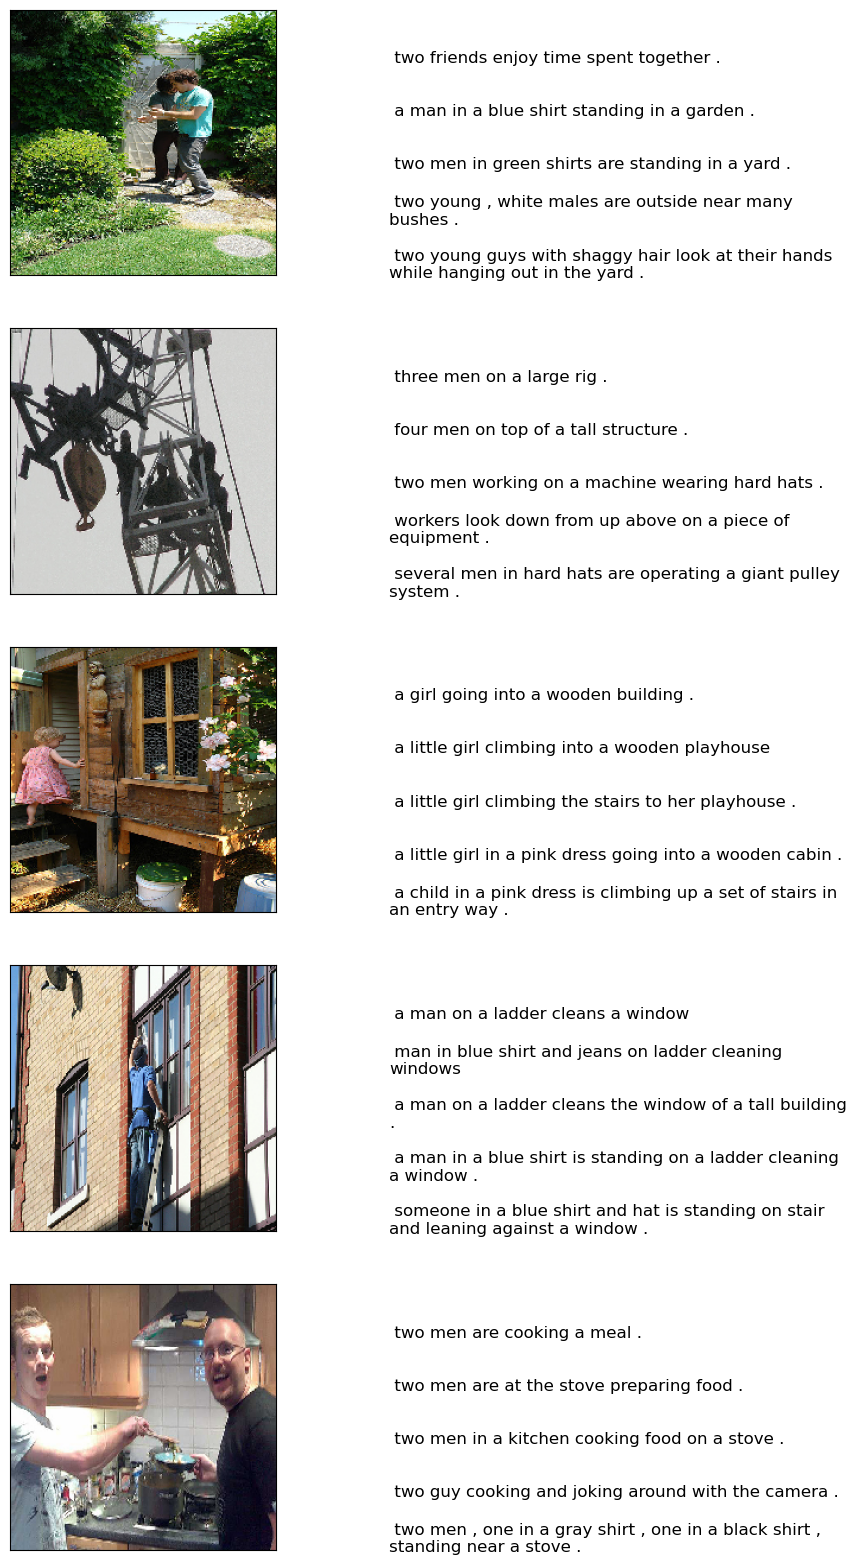

In [6]:
# Define the directory containing images
dir_Flickr_jpg = "images/flickr30k_images"  
npic = 5  # Number of images to display
npix = 224  # Image size (224x224)

# Set up the figure size
fig = plt.figure(figsize=(10, 20))
count = 1

# Loop through the first 5 unique filenames
for jpgfnm in uni_filenames[:npic]:
    # Construct the full file path for each image
    filename = f"{dir_Flickr_jpg}/{jpgfnm}"
    
    # Retrieve the captions for the current image
    captions = list(df_txt["caption"].loc[df_txt["filename"] == jpgfnm].values)
    
    # Load the image with the specified target size
    image_load = load_img(filename, target_size=(npix, npix))
    
    # Display the image
    ax = fig.add_subplot(npic, 2, count, xticks=[], yticks=[])
    ax.imshow(image_load)
    count += 1
    
    # Display the captions
    ax = fig.add_subplot(npic, 2, count)
    plt.axis('off')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, len(captions))
    for i, caption in enumerate(captions):
        ax.text(0, i, caption, fontsize=12, wrap=True)
    count += 1

plt.show()

### 7. Data Preparation and Pre-processing

#### 7.1 Text Preparation (Handling Missing Values, Vocabulary Size, Frequent Words)

In [7]:
# Define a function to create a DataFrame with word counts
def df_word(df_txt):
    # Initialize an empty list to hold all words from captions
    vocabulary = []
    
    # Loop through each caption, filtering out NaN values, and split into words
    for txt in df_txt['caption'].dropna().values:  # dropna() removes NaN captions
        vocabulary.extend(txt.split())
    
    # Print the unique vocabulary size
    print('Vocabulary Size:', len(set(vocabulary)))
    
    # Count the frequency of each word
    word_counts = Counter(vocabulary)
    
    # Create a DataFrame with words and their counts, sorted by frequency
    dfword = pd.DataFrame({"word": list(word_counts.keys()), "count": list(word_counts.values())})
    dfword = dfword.sort_values("count", ascending=False).reset_index(drop=True)
    
    return dfword

# Generate the dfword DataFrame with word counts
dfword = df_word(df_txt)

# Display the top 3 most frequent words
dfword.head(3)


Vocabulary Size: 20321


,word,count
0,a,271697
1,.,151037
2,in,83466


#### 7.2 Least and Most Frequently Appearing Words

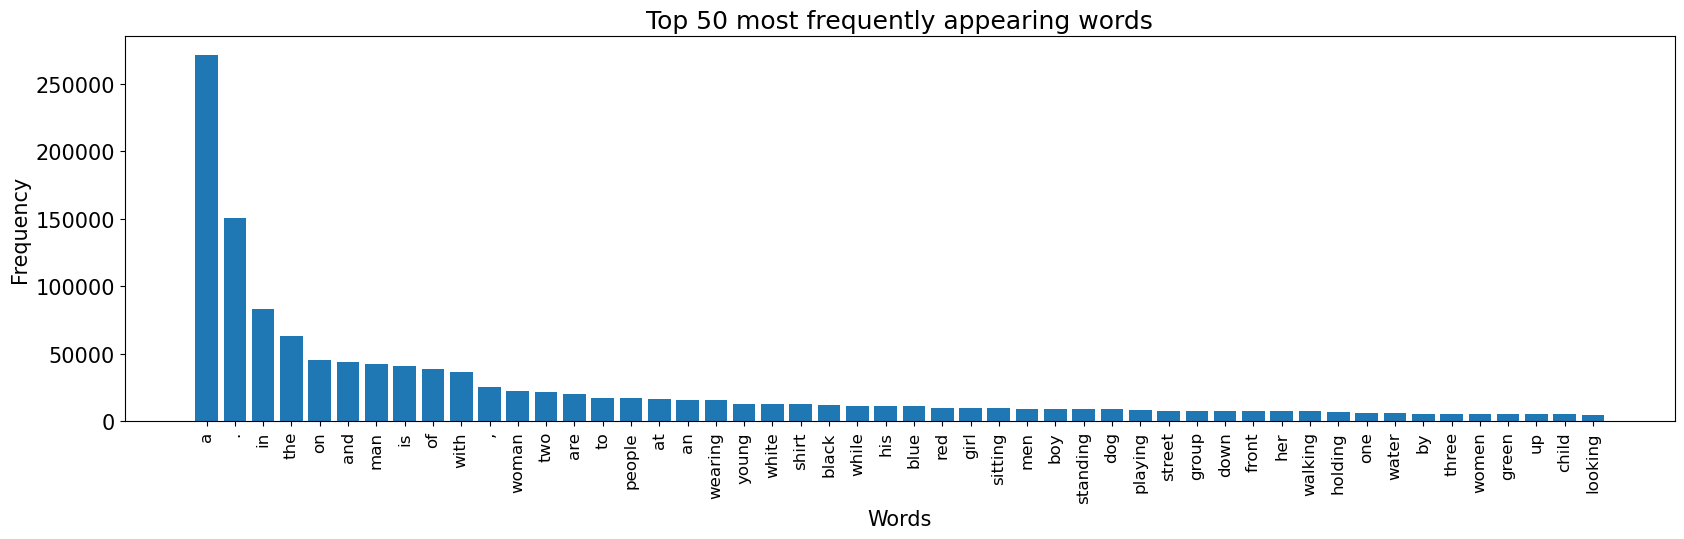

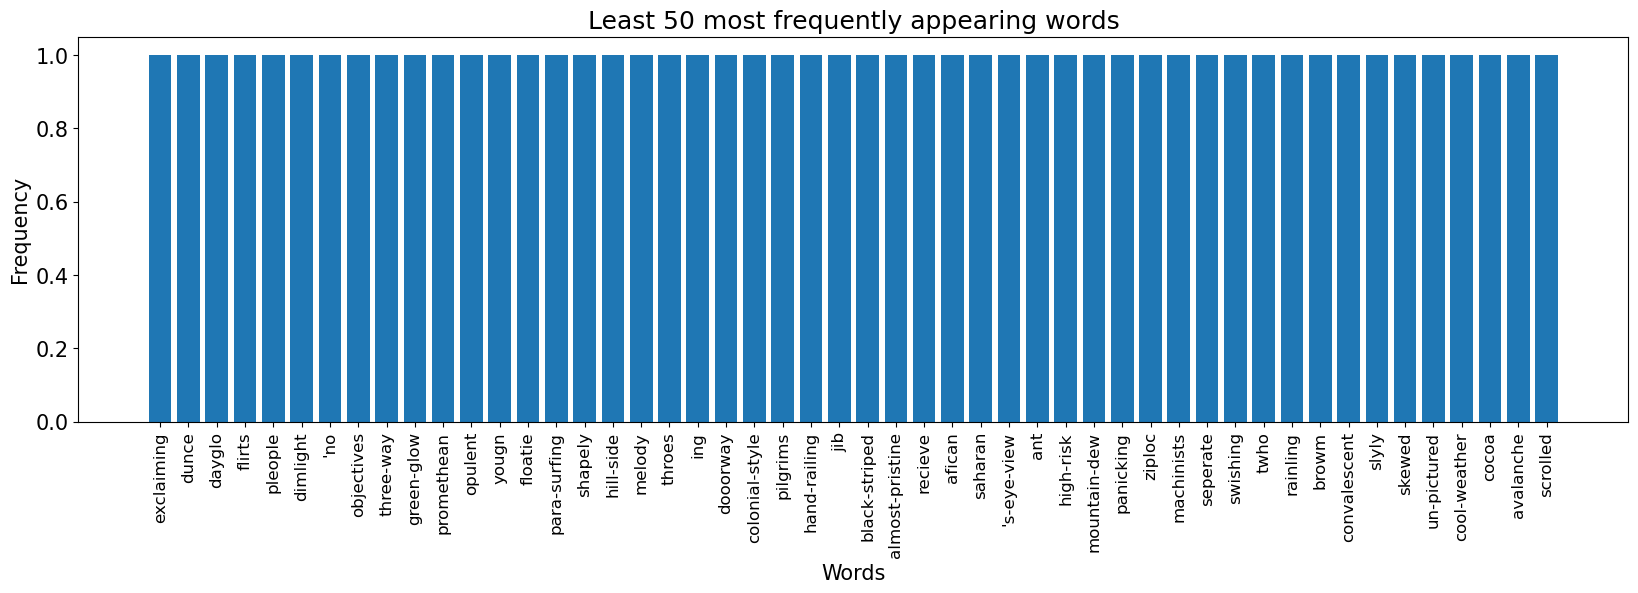

In [8]:
# Number of top/bottom words to display
topn = 50

# Function to plot the word frequency histogram
def plthist(dfsub, title="The top 50 most frequently appearing words"):
    plt.figure(figsize=(20, 5))
    plt.bar(dfsub.index, dfsub["count"])
    plt.yticks(fontsize=15)
    plt.xticks(dfsub.index, dfsub["word"], rotation=90, fontsize=12)
    plt.title(title, fontsize=18)
    plt.xlabel("Words", fontsize=15)
    plt.ylabel("Frequency", fontsize=15)
    plt.show()

# Plot the top 50 most frequently appearing words
plthist(dfword.iloc[:topn, :], title="Top 50 most frequently appearing words")

# Plot the least 50 most frequently appearing words
plthist(dfword.iloc[-topn:, :], title="Least 50 most frequently appearing words")

### 8. Define Functions to Clean the Captions

In [9]:
# example text
text_original = "The quick brown fox, aged 5, jumped over 12 lazy dogs! He said: 'Hello World!' at 6:00 pm."
print("Original Text:\n", text_original)

# Function to remove punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

# Function to remove single-character words
def remove_single_character(text):
    return ' '.join([word for word in text.split() if len(word) > 1])

# Function to remove words with numeric characters
def remove_numeric(text, printTF=False):
    words = []
    for word in text.split():
        is_alpha = word.isalpha()
        if printTF:
            print(f"    {word:10} : {is_alpha}")
        if is_alpha:
            words.append(word)
    return ' '.join(words)

# Process the text using each function sequentially
print("\nRemoving punctuations...")
text_no_punctuation = remove_punctuation(text_original)
print(text_no_punctuation)

print("\nRemoving single-character words...")
text_len_more_than1 = remove_single_character(text_no_punctuation)
print(text_len_more_than1)

print("\nRemoving words with numeric characters...")
text_no_numeric = remove_numeric(text_len_more_than1, printTF=True)
print("\nFinal Processed Text:\n", text_no_numeric)


Original Text:
 The quick brown fox, aged 5, jumped over 12 lazy dogs! He said: 'Hello World!' at 6:00 pm.

Removing punctuations...
The quick brown fox aged 5 jumped over 12 lazy dogs He said Hello World at 600 pm

Removing single-character words...
The quick brown fox aged jumped over 12 lazy dogs He said Hello World at 600 pm

Removing words with numeric characters...
    The        : True
    quick      : True
    brown      : True
    fox        : True
    aged       : True
    jumped     : True
    over       : True
    12         : False
    lazy       : True
    dogs       : True
    He         : True
    said       : True
    Hello      : True
    World      : True
    at         : True
    600        : False
    pm         : True

Final Processed Text:
 The quick brown fox aged jumped over lazy dogs He said Hello World at pm


#### 8.1 Apply to the dataset

In [10]:
# Define cleaning functions
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_single_character(text):
    return ' '.join([word for word in text.split() if len(word) > 1])

def remove_numeric(text):
    return ' '.join([word for word in text.split() if word.isalpha()])

# Combine cleaning functions into a single function
def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return text

# Apply the cleaning function to all captions in the DataFrame
df_txt['caption'] = df_txt['caption'].apply(lambda x: text_clean(x) if isinstance(x, str) else x)

# Display the first few cleaned captions to verify
df_txt.head()


,filename,index,caption
0,1000092795.jpg,0,two young guys with shaggy hair look at their ...
1,1000092795.jpg,1,two young white males are outside near many bu...
2,1000092795.jpg,2,two men in green shirts are standing in yard
3,1000092795.jpg,3,man in blue shirt standing in garden
4,1000092795.jpg,4,two friends enjoy time spent together


#### 8.2 Reduced Vacobulary After Cleaning

Vocabulary Size: 19735
Reduced Vocabulary Size: 19735


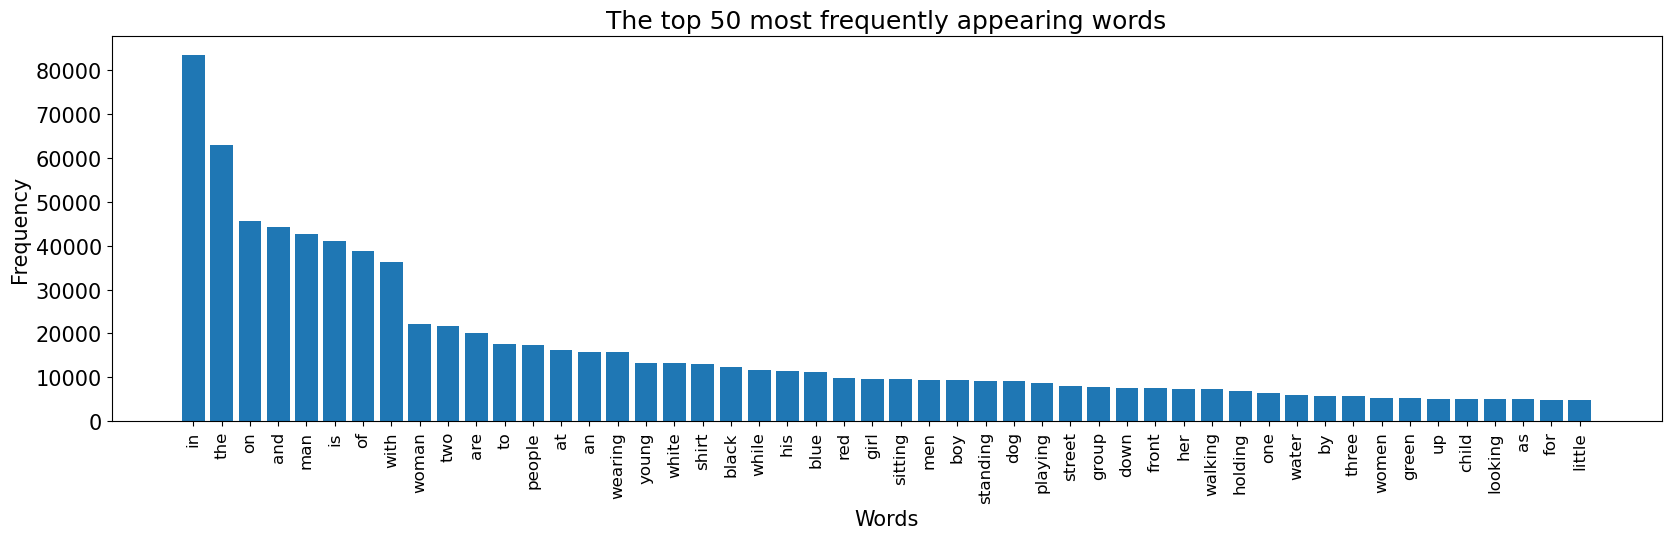

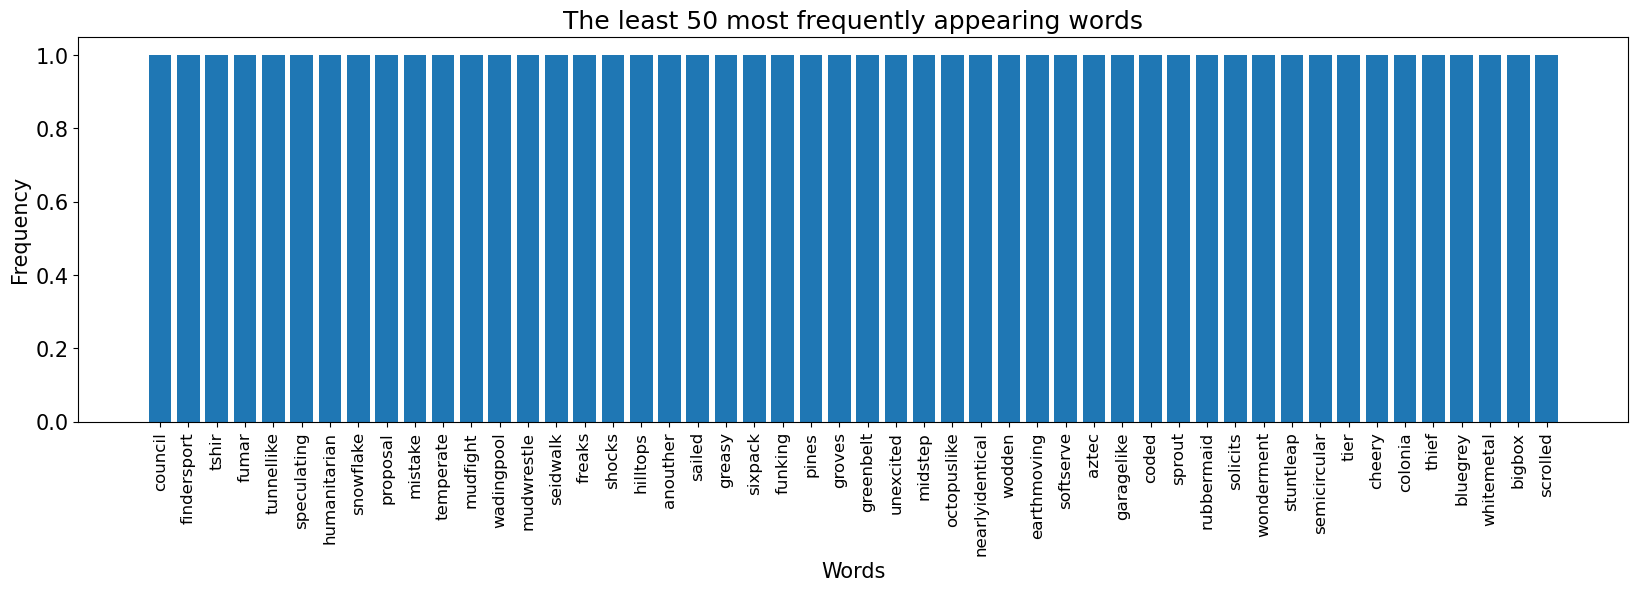

In [11]:
# Recalculate vocabulary and word frequency after cleaning
dfword = df_word(df_txt)

# Display vocabulary size reduction
print("Reduced Vocabulary Size:", len(dfword))

# Plot the top and least frequent words
plthist(dfword.head(topn), title="The top 50 most frequently appearing words")
plthist(dfword.tail(topn), title="The least 50 most frequently appearing words")

#### 8.3 Sequence Preparation

In [12]:
# Define function to add start and end sequence tokens, handling NaN values
def add_start_end_seq_token(captions):
    return ['startseq ' + str(txt) + ' endseq' if isinstance(txt, str) else 'startseq endseq' for txt in captions]

# Create a copy of df_txt
df_txt0 = deepcopy(df_txt)

# Add start and end tokens to each caption, handling NaN values
df_txt0['caption'] = add_start_end_seq_token(df_txt0['caption'].values)

# Display the first few rows to verify
df_txt0.head(5)


,filename,index,caption
0,1000092795.jpg,0,startseq two young guys with shaggy hair look ...
1,1000092795.jpg,1,startseq two young white males are outside nea...
2,1000092795.jpg,2,startseq two men in green shirts are standing ...
3,1000092795.jpg,3,startseq man in blue shirt standing in garden ...
4,1000092795.jpg,4,startseq two friends enjoy time spent together...


#### 8.3 Link Image and Caption Data

In [13]:
# Convert all values in the "index" column to strings, then strip spaces
df_txt["index"] = df_txt["index"].astype(str).str.strip()

# Keep only rows where "index" has valid numeric values (0 to 4) to exclude invalid rows
df_txt = df_txt[df_txt["index"].isin(['0', '1', '2', '3', '4'])]

# Convert "index" column back to integers for further processing
df_txt["index"] = df_txt["index"].astype(int)

# Now filter to keep only rows where "index" is 0 to select the first caption for each image
df_txt_filtered = df_txt[df_txt["index"] == 0]

# Check the first few rows to confirm the filtering
print("Sample data in df_txt_filtered after cleaning and filtering by index == 0:")
display(df_txt_filtered.head())

# Proceed with linking image paths and captions
dimages, dcaptions = [], []

for i, fnm in enumerate(df_txt_filtered["filename"]):
    image_path = os.path.join(Flickr_images_dir, fnm)  # Create full path to image
    if os.path.exists(image_path):  # Ensure the image file exists
        dimages.append(image_path)  # Add image path to dimages
        dcaptions.append(df_txt_filtered["caption"].iloc[i])  # Add the corresponding caption

# Display the number of linked images and captions
print(f"Linked {len(dimages)} images with {len(dcaptions)} captions.")


Sample data in df_txt_filtered after cleaning and filtering by index == 0:


,filename,index,caption
0,1000092795.jpg,0,two young guys with shaggy hair look at their ...
5,10002456.jpg,0,several men in hard hats are operating giant p...
10,1000268201.jpg,0,child in pink dress is climbing up set of stai...
15,1000344755.jpg,0,someone in blue shirt and hat is standing on s...
20,1000366164.jpg,0,two men one in gray shirt one in black shirt s...


Linked 31783 images with 31783 captions.


#### 8.4 Train-Test Split

In [14]:
# Assuming `dimages` contains image paths and `dcaptions` contains captions
# Perform an 80-20 split for training and testing
train_images, test_images, train_captions, test_captions = train_test_split(dimages, dcaptions, test_size=0.2, random_state=42)

# Confirm the split
print("Training set:", len(train_images), "images,", len(train_captions), "captions")
print("Testing set:", len(test_images), "images,", len(test_captions), "captions")


Training set: 25426 images, 25426 captions
Testing set: 6357 images, 6357 captions


#### 8.5 Tokenizer Setup and Tokenization

In [15]:
# Initialize the tokenizer with a maximum vocabulary size (optional)
nb_words = 8000
tokenizer = Tokenizer(num_words=nb_words)
tokenizer.fit_on_texts(train_captions)

# Vocabulary size
vocab_size = len(tokenizer.word_index) + 1
display("Vocabulary Size:", vocab_size)

# Convert train and test captions to sequences
train_sequences = tokenizer.texts_to_sequences(train_captions)
test_sequences = tokenizer.texts_to_sequences(test_captions)

# Determine max caption length (based on training set)
max_length = max(len(seq) for seq in train_sequences)
display("Max Caption Length:", max_length)

# Pad the sequences for uniform length
train_sequences = pad_sequences(train_sequences, maxlen=max_length, padding='post')
test_sequences = pad_sequences(test_sequences, maxlen=max_length, padding='post')

'Vocabulary Size:'

11821

'Max Caption Length:'

68

### 9. Image Captioning Model Architecture

In [16]:
# Define input layers
image_input = Input(shape=(256,))  # From the CNN feature extraction output
caption_input = Input(shape=(max_length,))  # Captions of max sequence length

# Caption (Text) Processing
embedding_dim = 256
caption_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True)(caption_input)
caption_lstm = LSTM(256)(caption_embedding)

# Combine Image and Caption (Merge)
merged = add([image_input, caption_lstm])
merged = Dense(256, activation='relu')(merged)

# Final output layer for vocabulary prediction
output = Dense(vocab_size, activation='softmax')(merged)

# Define the model
model = Model(inputs=[image_input, caption_input], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam')

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 68)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, 68, 256)           │       3,026,176 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ not_equal (NotEqual)          │ (None, 68)                │               0 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_1 (InputLayer)    │ (None, 256)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm (LSTM)                   │ (None, 256)               │         525,312 │ embedding[0][0],           │
│                               │                           │                 │ not_equal[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 256)               │               0 │ input_layer_1[0][0],       │
│                               │                           │                 │ lstm[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 256)               │          65,792 │ add[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 11821)             │       3,037,997 │ dense_1[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 6,655,277 (25.39 MB)

 Trainable params: 6,655,277 (25.39 MB)

 Non-trainable params: 0 (0.00 B)

#### 9.1 Prepare Image Features for the Generator

In [17]:
# Directory where processed image features will be saved
import os
image_features_dir = 'image_features/'

# Ensure the directory exists
os.makedirs(image_features_dir, exist_ok=True)

# Extract features from each image and save them
def extract_and_save_image_features(image_paths, cnn_model):
    for image_path in image_paths:
        # Load and preprocess the image
        img = load_img(image_path, target_size=(224, 224))
        img = img_to_array(img)
        img = np.expand_dims(img, axis=0)  # Add batch dimension
        img = img / 255.0  # Normalize pixel values
        
        # Extract features
        features = cnn_model.predict(img, verbose=0)
        
        # Save features with a unique name
        feature_path = os.path.join(image_features_dir, os.path.basename(image_path) + '.npy')
        np.save(feature_path, features)

# Extract features for training images only (as an example)
extract_and_save_image_features(train_images, cnn_model)


#### 9.2 Data Generator Function

In [22]:
import tensorflow as tf

def data_generator(image_paths, captions, tokenizer, max_length, vocab_size, batch_size=32):
    while True:
        # Shuffle data for each epoch
        indices = np.arange(len(image_paths))
        np.random.shuffle(indices)
        
        # Loop over the dataset in batches
        for i in range(0, len(image_paths), batch_size):
            batch_indices = indices[i:i+batch_size]
            
            # Initialize batch data
            image_batch, input_sequences, target_words = [], [], []
            
            for idx in batch_indices:
                image_path = image_paths[idx]
                caption = captions[idx]
                
                # Load precomputed image features
                feature_path = os.path.join(image_features_dir, os.path.basename(image_path) + '.npy')
                image_features = np.load(feature_path)
                
                # Prepare caption sequence data
                sequence = tokenizer.texts_to_sequences([caption])[0]
                for j in range(1, len(sequence)):
                    # Input and target sequence split
                    in_seq, out_seq = sequence[:j], sequence[j]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # Add data to batch
                    image_batch.append(image_features[0])  # Single feature vector
                    input_sequences.append(in_seq)
                    target_words.append(out_seq)
            
            # Convert lists to TensorFlow tensors for compatibility
            yield [tf.convert_to_tensor(image_batch), tf.convert_to_tensor(input_sequences)], tf.convert_to_tensor(target_words)


#### 9.3 Test the Generator with Model

In [23]:
# Instantiate the generator for a small batch
batch_size = 32
train_gen = data_generator(train_images, train_captions, tokenizer, max_length, vocab_size, batch_size=batch_size)

# Fetch a sample batch to verify
[img_batch, cap_batch], target_batch = next(train_gen)
print("Image batch shape:", img_batch.shape)
print("Caption batch shape:", cap_batch.shape)
print("Target batch shape:", target_batch.shape)


Image batch shape: (486, 256)
Caption batch shape: (486, 68)
Target batch shape: (486, 11821)
